### References
- https://arxiv.org/pdf/1805.08318

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import v2 as T
from torchvision.transforms.functional import convert_image_dtype
import torchvision.utils as vutils
import random
from tqdm import tqdm
from torch.nn.utils import spectral_norm
from torch.utils.data.dataset import random_split
from torchmetrics.image.fid import FrechetInceptionDistance

In [2]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 64
NZ = 256                    # Размер векторра шума z
NGF = 32                    # Размер модификатора каналов в генераторе
NDF = 32                    # Размер модификатора каналов в дискриминаторе
NC = 3                      # Количество каналов в изображении
BETA_1, BETA_2 = 0, 0.9     # B1, B2 коэффициенты оптимизатора
CLASS_N = 11                # Количество классов в датасете
K = 8                       # Множитель уменьшения количества каналов в слое self-attention

In [3]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [4]:
class SelfAttention(nn.Module):
    def __init__(self, input):
        super().__init__()
        self.f = nn.Conv2d(input, input // K, 1)
        self.g = nn.Conv2d(input, input // K, 1)
        self.h = nn.Conv2d(input, input // K, 1)
        self.v = nn.Conv2d(input // K, input, 1)
        self.softmax = nn.Softmax(dim=-1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch, channels, width, height = x.shape
        f = self.f(x).view(batch, -1, width * height)                   # BxCxWxH -> BxCxN | N(W*H)
        f = torch.transpose(f, 1, 2)                                    # BxCxN -> BxNxC
        g = self.g(x).view(batch, -1, width * height)                   # BxCxWxH -> BxCxN
        h = self.h(x).view(batch, -1, width * height)                   # BxCxWxH -> BxCxN
        attention = self.softmax(torch.bmm(f, g))                       # BxNxC x BxCxN -> BxNxN
        attention = torch.bmm(h, attention)                             # BxCxN x BxNxN -> BxCxN
        attention = attention.view(batch, channels // K, width, height) # BxCxN -> BxCxWxH
        o = self.v(attention)
        out = x + o * self.gamma
        return out

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Sequential(
            # NZ
            spectral_norm(nn.ConvTranspose2d(NZ, NGF * 8, 8, 1, 0, bias=False)),
            nn.BatchNorm2d(NGF * 8),
            nn.ReLU(True),
        )
        self.l2 = nn.Sequential(
            # ngf*8 x 8 x 8 
            spectral_norm(nn.ConvTranspose2d(NGF * 8, NGF * 4, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(NGF * 4),
            nn.ReLU(True),
        )
        self.l3 = nn.Sequential(
            # ngf*4 x 16 x 16
            spectral_norm(nn.ConvTranspose2d(NGF * 4, NGF * 2, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(NGF * 2),
            nn.ReLU(True),
        )
        self.l4 = nn.Sequential(
            # ngf*2 x 32 x 32
            spectral_norm(nn.ConvTranspose2d(NGF * 2, NGF , 4, 2, 1, bias=False)),
            nn.BatchNorm2d(NGF),
            nn.ReLU(True)
        )
        self.l5 = nn.Sequential(
            # ngf x 64 x 64
            nn.ConvTranspose2d(NGF, NC, 4, 2, 1, bias=False),
            nn.Tanh(),
        )
        self.att = SelfAttention(NGF* 8)

    def forward(self, x, rnd=0.005):
        x = self.l1(x)
        x = self.att(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        x = self.l5(x)
        noise = (rnd**0.5)*torch.randn(x.shape, device=DEVICE).detach()
        return x + noise

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = nn.Sequential(
            # nc x 128 x 128
            spectral_norm(nn.Conv2d(NC, NDF, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(NDF),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.l2 = nn.Sequential(
            # ndf x 64 x 64
            spectral_norm(nn.Conv2d(NDF, NDF * 2, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(NDF * 2),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.l3 = nn.Sequential(
            # ndf*2 x 32 x 32
            spectral_norm(nn.Conv2d(NDF * 2, NDF * 4, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(NDF * 4),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.l4 = nn.Sequential(
            # ndf*4 x 16 x 16
            spectral_norm(nn.Conv2d(NDF * 4, NDF * 8, 4, 2, 1, bias=False)),
            nn.BatchNorm2d(NDF * 8),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.image_classification = nn.Sequential(
            nn.Conv2d(NDF * 8, CLASS_N, 8, 1, 0, bias=False),
            nn.Sigmoid()
        )
        self.fake_classification = nn.Sequential(
            nn.Conv2d(NDF * 8, 1, 8, 1, 0, bias=False),
        )
        self.att = SelfAttention(NDF*8)

    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.l4(x)
        x = self.att(x)
        fake = self.fake_classification(x)
        label = self.image_classification(x)
        return fake, label

In [6]:
def train(models, data_loader: DataLoader, optimizers: tuple, class_loss_fn, rnd=0.005):
    D, G = models
    G.train()
    D.train()

    d_optim, g_optim = optimizers
    train_d_loss, train_g_loss = 0, 0

    for real_img, class_label in data_loader:
        real_img, class_label = real_img.to(DEVICE), class_label.to(DEVICE)
        batch_size = real_img.size(0)

        fake_img = G(torch.randn(batch_size, NZ, 1, 1, device=DEVICE), rnd)

        # добавляем шум в входные данные
        real_img = real_img + (rnd**0.5)*torch.randn(real_img.shape, device=DEVICE).detach()
       
        # тренируем дискриминатор
        d_optim.zero_grad()
        # реальные изображения
        true_outs, label = D(real_img)
        d_real_loss = torch.nn.ReLU()(1.0 - true_outs).mean()
        d_real_loss = d_real_loss + class_loss_fn(label.squeeze(2, 3), class_label)
        d_real_loss.backward()

        # фейковые изображения
        fake_outs, _ = D(fake_img.detach())
        d_fake_loss = torch.nn.ReLU()(1.0 + fake_outs).mean()
        d_fake_loss.backward()  
        d_optim.step()
        
        # тренируем генератор
        g_optim.zero_grad()
        fake_outs_, _ = D(fake_img)
        g_loss = -fake_outs_.mean()
        g_loss.backward()
        g_optim.step()

        train_d_loss += (d_real_loss + d_fake_loss).item()
        train_g_loss += g_loss.item()

    train_g_loss /= len(data_loader)
    train_d_loss /= len(data_loader)

    return train_d_loss, train_g_loss

In [7]:
@torch.no_grad()
def rescale(tensor):
    tensor -= tensor.min() 
    tensor /= tensor.max() 
    return tensor

@torch.no_grad()
def eval(model, data_loader, fid):
    G = model
    G.to(DEVICE)
    G.eval()

    for real_img, _ in data_loader:
        real_img = real_img.to(DEVICE)
        batch_size = real_img.size(0)
        fake_img = G(torch.randn(batch_size, NZ, 1, 1, device=DEVICE))

        fid.update(convert_image_dtype(rescale(real_img), torch.uint8), real=True)
        fid.update(convert_image_dtype(rescale(fake_img), torch.uint8), real=False)

    score = fid.compute()
    fid.reset()
    return score

In [8]:
image_dataset = ImageFolder(
    root='planets\\',
    transform=T.Compose([
        T.Resize(128),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]))

train_data , eval_data = random_split(image_dataset, (int(len(image_dataset) * 0.8), len(image_dataset) - int(len(image_dataset) * 0.8)))
data_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
eval_data_loader = torch.utils.data.DataLoader(eval_data, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
G = Generator()
D = Discriminator()

G.apply(weights_init)
D.apply(weights_init)

G.to(DEVICE)
D.to(DEVICE)

g_optim = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(BETA_1, BETA_2))
d_optim = torch.optim.Adam(D.parameters(), lr=6e-4, betas=(BETA_1, BETA_2))
class_loss_fn = nn.CrossEntropyLoss()
fid = FrechetInceptionDistance(feature=2048, reset_real_features=False).to(DEVICE)

In [10]:
fix_noise = torch.randn(16, NZ, 1, 1, device=DEVICE)


def plot_examples(title=None):
    G.eval()
    D.eval()

    plt.figure(figsize=(10, 4))
    images = G(fix_noise)

    plt.imshow(np.transpose(vutils.make_grid(images.cpu(), padding=5, normalize=True), (1, 2, 0)))
    if title:
        plt.title(title)
    plt.show()

epoch:1, d loss:2.5079215698772006, g loss:7.099878895613882, fid:413.3779602050781
epoch:2, d loss:2.7541960411601596, g loss:8.542895714441935, fid:421.1787414550781
epoch:3, d loss:2.934817658530341, g loss:8.463508850998348, fid:370.22637939453125
epoch:4, d loss:2.908994515736898, g loss:9.00785200463401, fid:411.98553466796875
epoch:5, d loss:1.8757421904140048, g loss:8.699155807495117, fid:384.74456787109375
epoch:6, d loss:2.5934461222754583, g loss:10.008758319748772, fid:374.92095947265625
epoch:7, d loss:2.430224816004435, g loss:9.351714624298943, fid:379.9599914550781
epoch:8, d loss:3.1165130734443665, g loss:10.101722856362661, fid:333.038330078125
epoch:9, d loss:1.6188139253192477, g loss:7.647196107440525, fid:356.0511169433594
epoch:10, d loss:3.2074652314186096, g loss:7.361651051375601, fid:326.66082763671875
epoch:11, d loss:2.285442974832323, g loss:9.136872079637316, fid:356.84906005859375
epoch:12, d loss:2.7869458463456898, g loss:6.939747335182296, fid:306.2

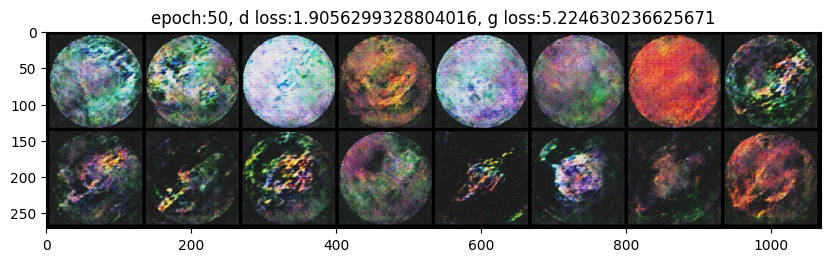

epoch:51, d loss:1.953252461221483, g loss:5.539100190003713, fid:239.9049835205078
epoch:52, d loss:2.245652609401279, g loss:5.638611581590441, fid:240.9783477783203
epoch:53, d loss:1.7750706407758925, g loss:5.596823533376058, fid:245.90380859375
epoch:54, d loss:2.0585869087113275, g loss:5.659868811567624, fid:226.1552734375
epoch:55, d loss:2.240781525770823, g loss:5.633093860414293, fid:229.72955322265625
epoch:56, d loss:1.8521215584543016, g loss:5.736211021741231, fid:240.0220947265625
epoch:57, d loss:2.0416265196270413, g loss:5.516357269552019, fid:235.5770721435547
epoch:58, d loss:2.0580672952863903, g loss:6.04577335384157, fid:233.70675659179688
epoch:59, d loss:1.9397136966387432, g loss:5.751301268736522, fid:244.5231475830078
epoch:60, d loss:1.9592697951528761, g loss:5.841368695100148, fid:250.0853271484375
epoch:61, d loss:2.1564015878571405, g loss:5.640501353475782, fid:261.2575988769531
epoch:62, d loss:2.279671801461114, g loss:5.270917925569746, fid:237.79

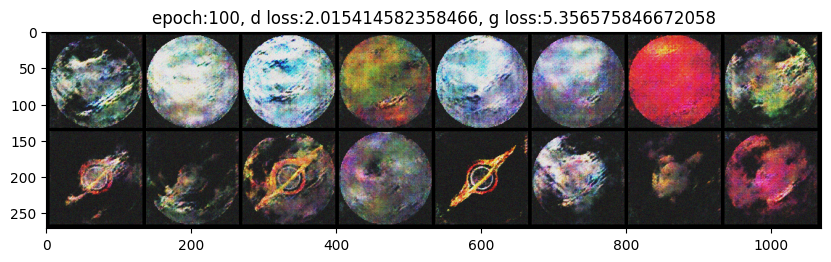

epoch:101, d loss:1.7652568486001756, g loss:5.510414799054463, fid:221.50277709960938
epoch:102, d loss:1.9562388724750943, g loss:5.155399600664775, fid:224.91195678710938
epoch:103, d loss:2.0511917008294, g loss:5.279404895173179, fid:233.66749572753906
epoch:104, d loss:1.8422094451056585, g loss:5.687115841441685, fid:225.8352508544922
epoch:105, d loss:1.7443090677261353, g loss:5.92651547325982, fid:240.57330322265625
epoch:106, d loss:2.1684134801228843, g loss:5.613266156779395, fid:224.06051635742188
epoch:107, d loss:1.8389188713497586, g loss:5.411323070526123, fid:214.22286987304688
epoch:108, d loss:1.825369159380595, g loss:5.3444305128521385, fid:223.10166931152344
epoch:109, d loss:1.8253653314378526, g loss:5.939147459136115, fid:227.20057678222656
epoch:110, d loss:1.873566918902927, g loss:5.770946780840556, fid:233.00161743164062
epoch:111, d loss:1.7840143971972995, g loss:5.709878815544976, fid:212.32296752929688
epoch:112, d loss:1.9672369559605916, g loss:5.69

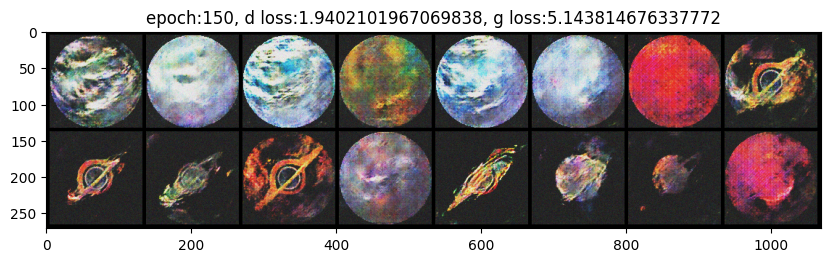

epoch:151, d loss:1.8578241335021124, g loss:5.5799800157547, fid:214.84324645996094
epoch:152, d loss:1.697091003259023, g loss:5.509591579437256, fid:220.71102905273438
epoch:153, d loss:1.9007569352785747, g loss:5.538153780831231, fid:207.43296813964844
epoch:154, d loss:1.811935351954566, g loss:5.375105513466729, fid:216.4068603515625
epoch:155, d loss:1.8971224758360121, g loss:5.479441682497661, fid:209.2847137451172
epoch:156, d loss:1.9515743851661682, g loss:5.067840933799744, fid:222.09564208984375
epoch:157, d loss:1.8641321592860751, g loss:5.583051800727844, fid:207.9879608154297
epoch:158, d loss:1.7424158387713962, g loss:5.436477568414476, fid:211.24317932128906
epoch:159, d loss:1.8072674208217197, g loss:5.136142161157396, fid:212.3461151123047
epoch:160, d loss:1.978392031457689, g loss:5.769770860671997, fid:206.92543029785156
epoch:161, d loss:1.7394109898143344, g loss:5.300009846687317, fid:220.5902557373047
epoch:162, d loss:1.8220496508810256, g loss:5.079298

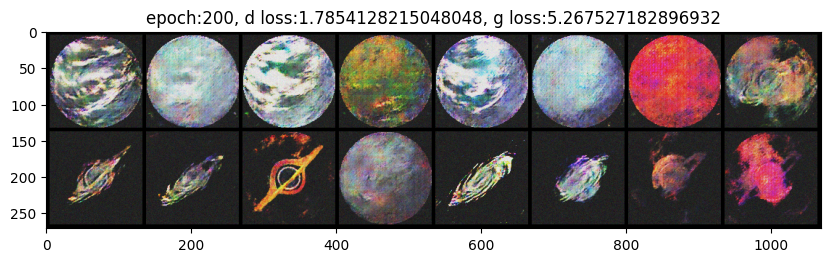

epoch:201, d loss:1.8212309347258673, g loss:5.316769215795729, fid:217.48008728027344
epoch:202, d loss:1.7810712721612718, g loss:5.175811820560032, fid:212.41212463378906
epoch:203, d loss:1.7910720904668171, g loss:5.206680138905843, fid:208.53240966796875
epoch:204, d loss:1.7459677788946364, g loss:5.3176374435424805, fid:206.39947509765625
epoch:205, d loss:1.9685113496250577, g loss:5.103411058584849, fid:205.75897216796875
epoch:206, d loss:1.7003943588998582, g loss:5.186038666301304, fid:217.53175354003906
epoch:207, d loss:1.7837606602244906, g loss:5.064244627952576, fid:208.57241821289062
epoch:208, d loss:1.746571613682641, g loss:4.989144974284702, fid:211.02664184570312
epoch:209, d loss:1.8519553409682379, g loss:5.4148230287763806, fid:228.80239868164062
epoch:210, d loss:1.7385606567064922, g loss:5.020495613416036, fid:204.4571990966797
epoch:211, d loss:1.9385132590929668, g loss:5.154400812255012, fid:211.0112762451172
epoch:212, d loss:1.8184166020817227, g loss

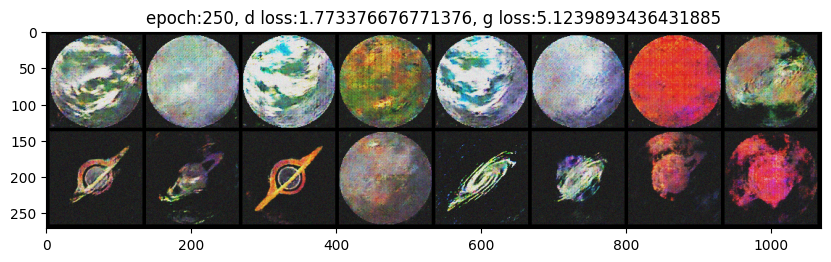

epoch:251, d loss:1.6820450160238478, g loss:5.570388555526733, fid:199.70840454101562
epoch:252, d loss:1.7817269563674927, g loss:5.503729052013821, fid:202.96351623535156
epoch:253, d loss:1.782504399617513, g loss:5.113903005917867, fid:203.57806396484375
epoch:254, d loss:1.7847565015157063, g loss:5.250752104653253, fid:201.9025421142578
epoch:255, d loss:1.7173285484313965, g loss:5.389774296018812, fid:210.6064910888672
epoch:256, d loss:1.6954150398572285, g loss:5.301621052953932, fid:204.12745666503906
epoch:257, d loss:1.7481218245294359, g loss:5.478644622696771, fid:204.81646728515625
epoch:258, d loss:1.7428275810347662, g loss:5.337379879421658, fid:208.45166015625
epoch:259, d loss:1.8341463009516399, g loss:5.244453681839837, fid:223.27691650390625
epoch:260, d loss:1.6715708242522345, g loss:5.084789805942112, fid:200.59519958496094
epoch:261, d loss:1.810584372944302, g loss:5.369908875889248, fid:214.11468505859375
epoch:262, d loss:1.6483439869350858, g loss:5.262

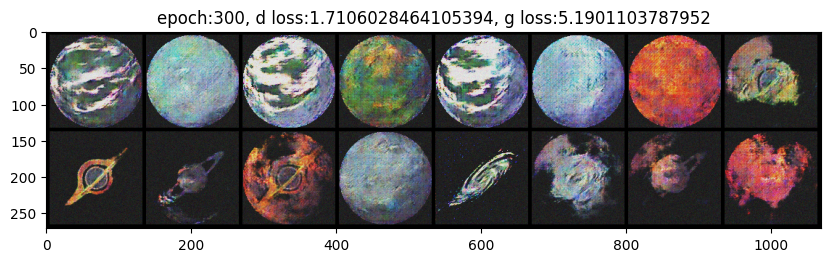

epoch:301, d loss:1.728711227575938, g loss:5.448434942298466, fid:203.58843994140625
epoch:302, d loss:1.7114190459251404, g loss:5.46979754500919, fid:219.9612274169922
epoch:303, d loss:1.7524498369958665, g loss:5.198986212412517, fid:215.86170959472656
epoch:304, d loss:1.708301630285051, g loss:5.412008788850573, fid:208.20457458496094
epoch:305, d loss:1.7235136561923556, g loss:5.341540190908644, fid:207.74591064453125
epoch:306, d loss:1.8348814911312528, g loss:5.448255913125144, fid:213.75186157226562
epoch:307, d loss:1.6458753943443298, g loss:5.365498609013027, fid:216.7557830810547
epoch:308, d loss:1.6730615496635437, g loss:5.6241576539145575, fid:215.89146423339844
epoch:309, d loss:1.725769579410553, g loss:5.370121412807041, fid:201.00682067871094
epoch:310, d loss:1.6726542115211487, g loss:5.433296839396159, fid:201.6962127685547
epoch:311, d loss:1.6888798144128587, g loss:5.490045679940118, fid:206.15863037109375
epoch:312, d loss:1.7047362195120916, g loss:5.70

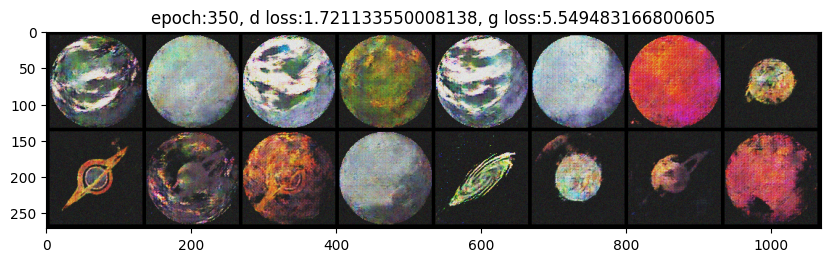

epoch:351, d loss:1.7515593038664923, g loss:5.3313777049382525, fid:191.68109130859375
epoch:352, d loss:1.7409064239925809, g loss:5.770968344476488, fid:201.4793243408203
epoch:353, d loss:1.6689162651697795, g loss:5.443372474776374, fid:203.5342254638672
epoch:354, d loss:1.772432181570265, g loss:5.412001159456041, fid:203.34579467773438
epoch:355, d loss:1.6958050727844238, g loss:5.57317140367296, fid:199.92721557617188
epoch:356, d loss:1.7117601831754048, g loss:5.4274859295950995, fid:196.87640380859375
epoch:357, d loss:1.6534548732969496, g loss:5.5446792708502874, fid:201.80673217773438
epoch:358, d loss:1.760516928301917, g loss:5.745050986607869, fid:205.95086669921875
epoch:359, d loss:1.65972238779068, g loss:5.793269872665405, fid:203.88919067382812
epoch:360, d loss:1.7331795162624783, g loss:5.446228477689955, fid:204.1813201904297
epoch:361, d loss:1.676445437802209, g loss:5.482876075638665, fid:202.8092041015625
epoch:362, d loss:1.6834339300791423, g loss:5.536

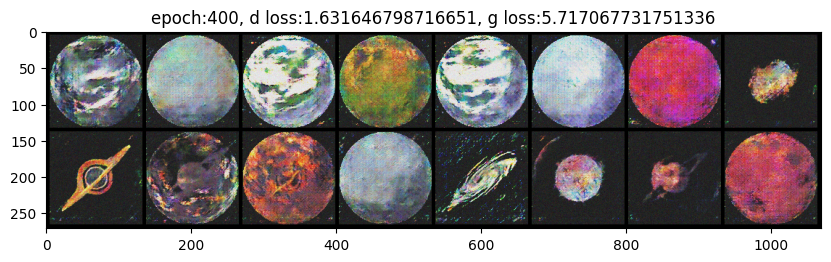

epoch:401, d loss:1.6776220401128132, g loss:5.956687556372748, fid:193.7476043701172
epoch:402, d loss:1.6960331598917644, g loss:5.8545786539713545, fid:202.5601806640625
epoch:403, d loss:1.6895177165667217, g loss:5.520102885034349, fid:207.85943603515625
epoch:404, d loss:1.73463194237815, g loss:5.659551137023502, fid:202.4479522705078
epoch:405, d loss:1.6150748133659363, g loss:5.923957930670844, fid:212.43067932128906
epoch:406, d loss:1.7580396466785007, g loss:5.660104248258802, fid:201.8039093017578
epoch:407, d loss:1.641336785422431, g loss:5.686716622776455, fid:206.1207733154297
epoch:408, d loss:1.6848259501987033, g loss:5.754684474733141, fid:202.00462341308594
epoch:409, d loss:1.6379906005329556, g loss:5.934477024608189, fid:207.24191284179688
epoch:410, d loss:1.6783232225312128, g loss:5.716720223426819, fid:211.6135711669922
epoch:411, d loss:1.7643988463613722, g loss:5.870282027456495, fid:210.1040802001953
epoch:412, d loss:1.6629276540544298, g loss:5.39150

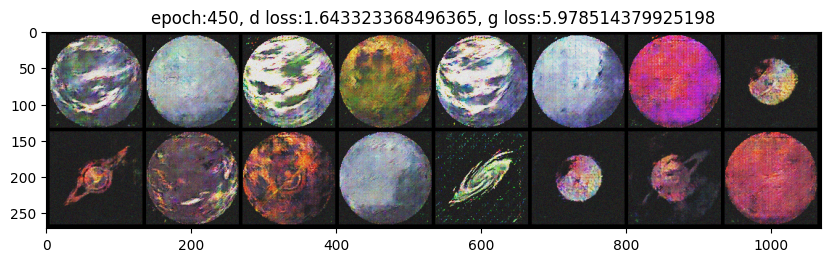

epoch:451, d loss:1.6258784996138678, g loss:5.95113926463657, fid:199.92843627929688
epoch:452, d loss:1.6227680643399556, g loss:6.068875418768989, fid:198.22776794433594
epoch:453, d loss:1.7488080925411649, g loss:6.428700314627753, fid:198.61614990234375
epoch:454, d loss:1.6963301963276334, g loss:5.906483186615838, fid:199.9477996826172
epoch:455, d loss:1.6743505597114563, g loss:5.658328307999505, fid:207.7406768798828
epoch:456, d loss:1.662773138946957, g loss:5.935565604103936, fid:199.36019897460938
epoch:457, d loss:1.7098085814052157, g loss:5.836081902186076, fid:195.2181854248047
epoch:458, d loss:1.6809999148050945, g loss:5.717248148388332, fid:200.51644897460938
epoch:459, d loss:1.6559968060917325, g loss:5.918773942523533, fid:191.65187072753906
epoch:460, d loss:1.7325299382209778, g loss:5.639412588543362, fid:197.4069366455078
epoch:461, d loss:1.692771057287852, g loss:6.014722082349989, fid:200.5026397705078
epoch:462, d loss:1.6706429653697543, g loss:5.9490

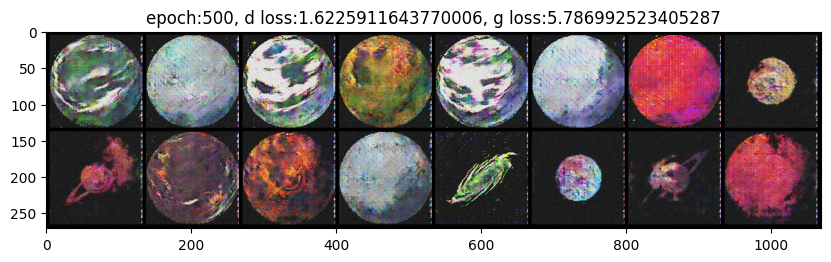

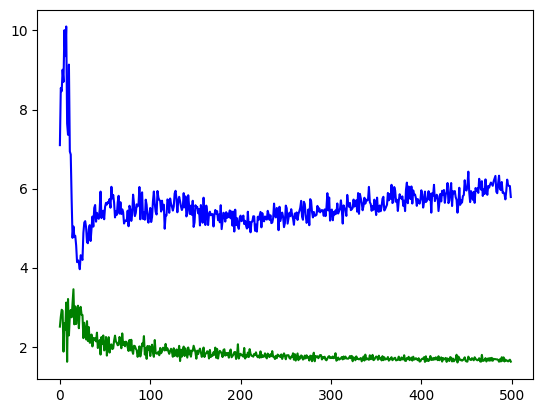

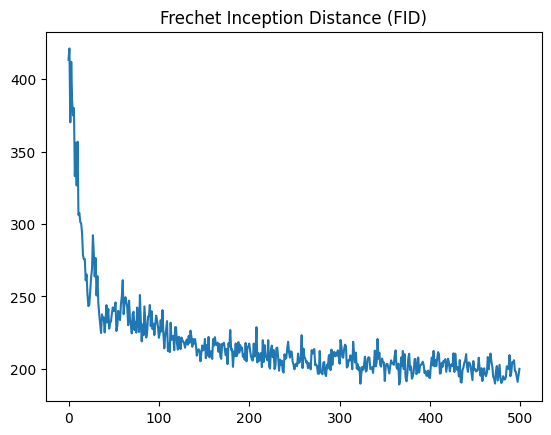

In [11]:
all_d_loss, all_g_loss, all_fid_score = [], [], []

rnd = random.uniform(0, 0.5)
for e in range(1, 501):
    d_loss, g_loss= train((D, G), data_loader, (d_optim, g_optim), class_loss_fn, rnd)
    all_d_loss.append(d_loss)
    all_g_loss.append(g_loss)

    fid_score = eval(G, eval_data_loader, fid)
    all_fid_score.append(fid_score.cpu())

    print(f'epoch:{e}, d loss:{d_loss}, g loss:{g_loss}, fid:{fid_score}')
    if e % 50 == 0:
        plot_examples(f'epoch:{e}, d loss:{d_loss}, g loss:{g_loss}')

plt.plot(all_d_loss, color='green')
plt.plot(all_g_loss, color='blue')
plt.show()

plt.plot(all_fid_score)
plt.title('Frechet Inception Distance (FID)')
plt.show()

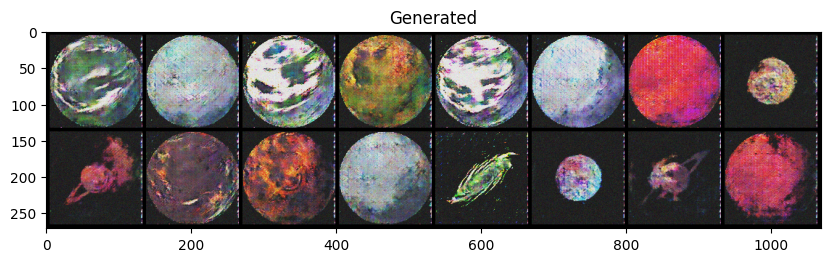

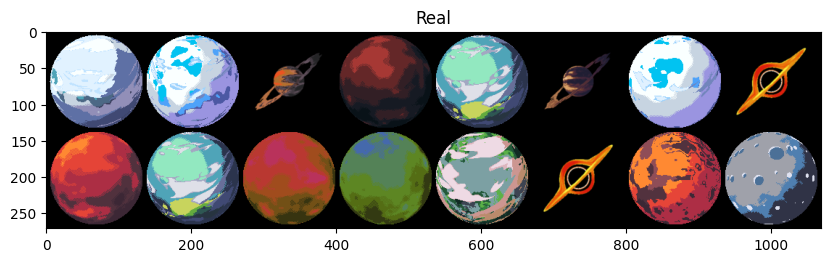

In [12]:
plot_examples('Generated')
plt.figure(figsize=(10, 4))
plt.imshow(np.transpose(vutils.make_grid(next(iter(data_loader))[0][:16], padding=5, normalize=True), (1, 2, 0)))
plt.title('Real')
plt.show()